In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4028, done.
remote: Counting objects: 100% (1216/1216), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 4028 (delta 1065), reused 1096 (delta 998), pack-reused 2812
Receiving objects: 100% (4028/4028), 651.38 MiB | 36.61 MiB/s, done.
Resolving deltas: 100% (2358/2358), done.
Updating files: 100% (248/248), done.


In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [7]:
train_dir=data_20_percent_path/'train'
test_dir=data_20_percent_path/'test'

In [8]:
## set up pre trained weigts
effnet_b2_weigts=torchvision.models.EfficientNet_B2_Weights.DEFAULT
## get transform
effnet_transform=effnet_b2_weigts.transforms()
##set up pretrained model
effnetb2=torchvision.models.efficientnet_b2(weights=effnet_b2_weigts)

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for parm in effnetb2.parameters():
  parm.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 153MB/s] 


In [9]:
effnet_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
#effnetb2

In [11]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [12]:
from torch.nn.modules.dropout import Dropout
effnetb2.classifier=nn.Sequential(Dropout(p=0.3,inplace=True),
                                  nn.Linear(in_features=1408,out_features=3))

In [13]:
## let's create fun to do that
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

  weigts=torchvision.models.EfficientNet_B2_Weights.DEFAULT

  eff_transform=weigts.transforms()

  eff_model=torchvision.models.efficientnet_b2(weigts)

  for parm in eff_model.parameters():
    parm.requires_grad=False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  eff_model.classifier=nn.Sequential(nn.Linear(in_features=1408,
                                               out_features=num_classes))

  return eff_model,eff_transform


In [14]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [15]:
summary(effnetb2,
        (1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [16]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [17]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)


# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

efffnet_res=engine.train(model=effnetb2,
                         train_dataloader= train_dataloader_effnetb2,
                         test_dataloader=test_dataloader_effnetb2,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=10,
                         device=device

                        )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9510 | train_acc: 0.5833 | test_loss: 0.6909 | test_acc: 0.9500
Epoch: 2 | train_loss: 0.6749 | train_acc: 0.8604 | test_loss: 0.5301 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.5188 | train_acc: 0.8854 | test_loss: 0.4514 | test_acc: 0.9256
Epoch: 4 | train_loss: 0.4439 | train_acc: 0.8833 | test_loss: 0.3847 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.3905 | train_acc: 0.8938 | test_loss: 0.3437 | test_acc: 0.9625
Epoch: 6 | train_loss: 0.3986 | train_acc: 0.8958 | test_loss: 0.3204 | test_acc: 0.9318
Epoch: 7 | train_loss: 0.3273 | train_acc: 0.9167 | test_loss: 0.3007 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.3130 | train_acc: 0.8896 | test_loss: 0.3047 | test_acc: 0.9256
Epoch: 9 | train_loss: 0.3410 | train_acc: 0.8771 | test_loss: 0.2619 | test_acc: 0.9625
Epoch: 10 | train_loss: 0.2919 | train_acc: 0.8917 | test_loss: 0.2445 | test_acc: 0.9625


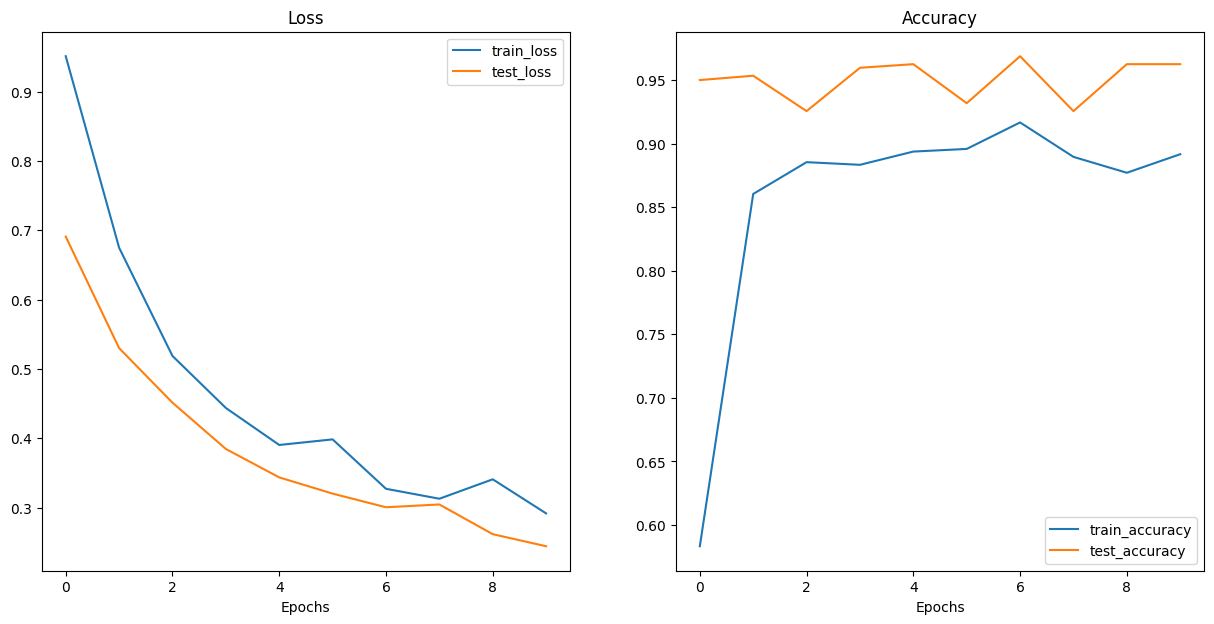

In [18]:
from helper_functions import plot_predictions
plot_loss_curves(efffnet_res)

In [19]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [20]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": efffnet_res["test_loss"][-1],
                  "test_acc": efffnet_res["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.24452677369117737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [23]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
from prompt_toolkit.filters import in_paste_mode
from torch.nn.modules import transformer
def create_vit_model(num_classes:int=3,
                     seed:int=42):

  weights=torchvision.models.ViT_B_16_Weights.DEFAULT

  transforme=weights.transforms()

  model=torchvision.models.vit_b_16(weights)


  for param in model.parameters():
    param.requires_grad=False

  torch.manual_seed(seed)

  model.heads=nn.Sequential(nn.Linear(in_features=768,
                                           out_features=num_classes))

  return model,transforme

In [25]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 253MB/s] 


In [26]:
from torchinfo import summary

summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [27]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [28]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


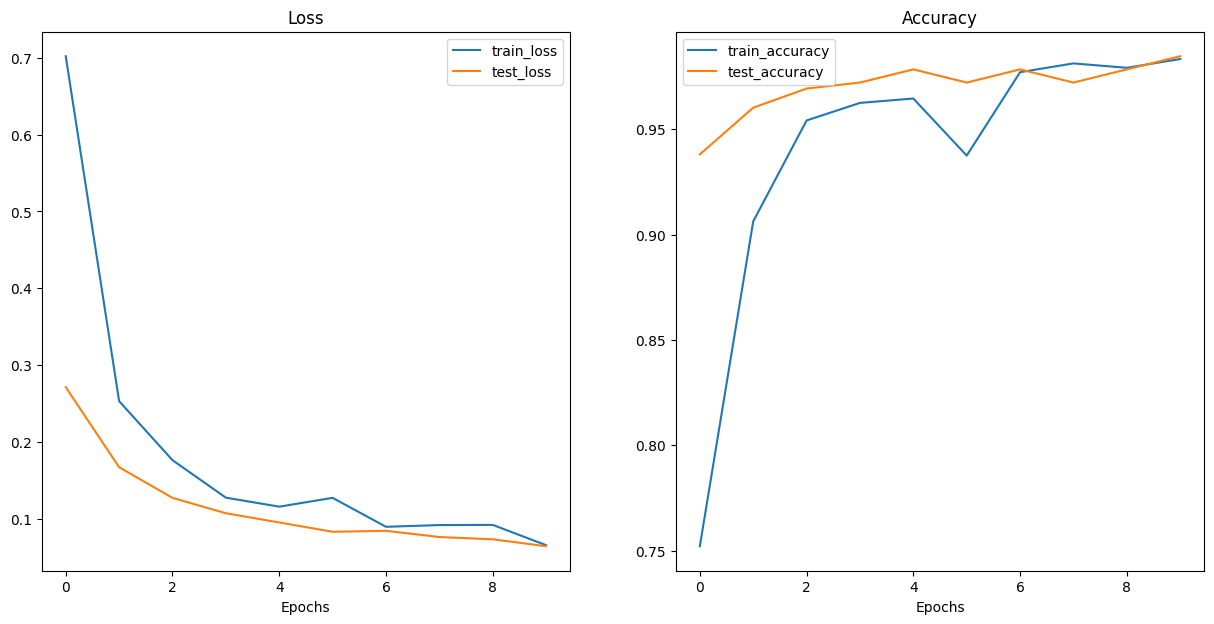

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [30]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [31]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [32]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [33]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443453952670097,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [34]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1063878.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/720302.jpg')]

In [35]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [36]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8729,
  'pred_class': 'sushi',
  'time_for_pred': 0.3084,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.918,
  'pred_class': 'sushi',
  'time_for_pred': 0.0965,
  'correct': True}]

In [38]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8729,sushi,0.3084,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9180,sushi,0.0965,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9673,sushi,0.0940,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9472,sushi,0.0944,True
4,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.5345,sushi,0.0967,True


In [39]:
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8729,sushi,0.3084,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9180,sushi,0.0965,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9673,sushi,0.0940,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9472,sushi,0.0944,True
4,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.5345,sushi,0.0967,True


In [40]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()


correct
True     144
False      6
Name: count, dtype: int64

In [41]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1011 seconds


In [42]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.24452677369117737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1011}

In [43]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
vit_test_pred_data_fram=pd.DataFrame(vit_test_pred_dicts)

In [45]:
vit_test_pred_data_fram.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5532,sushi,0.6056,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9951,sushi,0.4019,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9659,sushi,0.3935,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9963,sushi,0.3637,True
4,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.8780,sushi,0.3808,True


In [46]:
# Count the number of correct predictions
vit_test_pred_data_fram.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [47]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_data_fram.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.3929 seconds


In [48]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443453952670097,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.3929}

In [49]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.244527,96.25,7705221,29,0.1011,EffNetB2
1,0.064435,98.47,85800963,327,0.3929,ViT


In [50]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

In [10]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

NameError: name 'effnetb2' is not defined

In [52]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  start_time=timer()

  img=effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()

  with torch.inference_mode():
    pred_probs=torch.softmax(effnetb2(img),dim=1)

  pred_labels_and_probs={class_names[i]:float(pred_probs[0][1]) for i in range(len(class_names))}

  pred_time=round(timer()-start_time,5)

  return pred_labels_and_probs,pred_time

In [53]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]


# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dic,pred_time=predict(img=image)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg



In [54]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3227791.jpg']]

In [55]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://18d5ee821db7fbd29c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [3]:
import shutil
from pathlib import Path

foodvision_mini_demo_path=Path('foodvision_mini_demo_path/')

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,  exist_ok=True)
    
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
    



In [4]:
# Check what's in the folder
!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


In [9]:
import shutil
from pathlib import Path

#wxample dir
foodvision_mini_examples_path=foodvision_mini_demo_path/'examples'

foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]


# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to foodvision_mini_demo_path/examples/592799.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'

In [11]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[]